In [6]:
import pandas as pd
import os

df = pd.DataFrame()
"""
for json_file in os.listdir("dataset/jsonl/"):
    df = pd.concat([df, pd.read_json("dataset/jsonl/" + json_file, lines=True)])
    print(f"Added {json_file} to dataframe.")
"""
df = pd.read_json('dataset/jsonl/en-US.jsonl', lines=True)
df["locale"] = df["locale"].apply(lambda x: x.split("-")[0])

In [7]:
%run -i "preprocess_lang.ipynb"
%run -i "preprocess_nolang.ipynb"
%run -i "evaluation.ipynb"

In [8]:
from toolz.functoolz import pipe

params = [
    remove_punctuation,
    lowercase,
    tokenize,
    apply_stemming,
    encode_labels
]

df = pipe(
    df,
    *params
)


In [10]:
df['utt'] = df['utt'].apply(lambda x: " ".join(x))

print(f"Finished preprocessing dataset.\n\n")

Finished preprocessing dataset.




In [11]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer()
vectorized = vectorizer.fit_transform(df['utt'].to_list())


In [12]:
input_cols = [f'__{feature_name}' for feature_name in vectorizer.get_feature_names_out()]
output_cols = ['intent']
averages = [None, "macro", "weighted", "micro", "samples"]

In [13]:
count_vect_df = pd.DataFrame(vectorized.todense(), columns=input_cols)
df = pd.concat([df, count_vect_df], axis=1)

Best params for DecisionTreeClassifier: {'model__splitter': 'random', 'model__min_samples_split': 10, 'model__min_samples_leaf': 6, 'model__max_features': 3565, 'model__max_depth': 14, 'model__criterion': 'entropy'}
Evaluation metrics for RandomizedSearchCV
RandomizedSearchCV's default score metric: 0.35251497620954036
Classification report
              precision    recall  f1-score   support

           0     0.8846    0.6765    0.7667        34
           1     0.9375    0.7143    0.8108        21
           2     0.6667    0.6829    0.6747        41
           3     1.0000    0.0000    0.0000        11
           4     1.0000    0.0000    0.0000        32
           5     1.0000    0.0000    0.0000         6
           6     0.5000    0.1538    0.2353        13
           7     0.2184    0.3016    0.2533       126
           8     0.9583    0.3433    0.5055        67
           9     0.7667    0.7703    0.7685       209
          11     1.0000    0.0000    0.0000        72
        

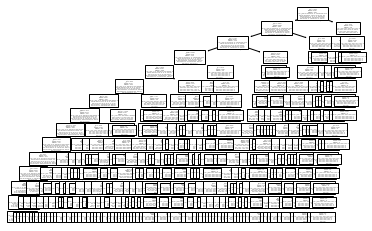

In [19]:
model1 = train_and_use_model(
    DecisionTreeClassifier(),
    {
        "model__criterion": ['gini', 'entropy'],
        'model__splitter': ['best', 'random'],
        "model__max_depth": range(1, 15),
        'model__max_features': range(1, len(input_cols)),
        "model__min_samples_split": range(2,15),
        "model__min_samples_leaf": range(1,7)
    },
    n_iter=20,
)

In [21]:
from sklearn.naive_bayes import MultinomialNB

model1 = train_and_use_model(
    MultinomialNB(),
    {
        "model__alpha": [0.1, 0.5, 1.0, 1.5, 2.0],
    },
    n_iter=1,
)

C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params for MultinomialNB: {'model__alpha': 0.5}
Evaluation metrics for RandomizedSearchCV
RandomizedSearchCV's default score metric: 0.6997935402618228
Classification report
              precision    recall  f1-score   support

           0     0.8333    0.7353    0.7812        34
           1     0.9333    0.6667    0.7778        21
           2     0.8095    0.8293    0.8193        41
           3     1.0000    0.5455    0.7059        11
           4     0.9474    0.5625    0.7059        32
           5     1.0000    0.0000    0.0000         6
           6     0.4706    0.6154    0.5333        13
           7     0.6250    0.7937    0.6993       126
           8     0.8630    0.9403    0.9000        67
           9     0.7539    0.9234    0.8301       209
          11     0.9365    0.8194    0.8741        72
          12     1.0000    0.3333    0.5000        15
          13     0.7353    0.8523    0.7895        88
          14     0.8000    0.3333    0.4706        12
          

In [ ]:
model3 = train_and_use_model(
    LogisticRegression(), 
    {
        "solver": ['liblinear'],
        "penalty": ['l2'],
        "C": [100, 10, 1.0, 0.1, 0.01],
        "dual": [True]    
    },
    n_iter=1
)